## Text analytics - tweets

### Load Libraries

In [47]:
# For data and matrix manipulation
import pandas as pd
import numpy as np

# For visualisation
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# For string manipulation
import re 
import string

# For text pre-processing
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Necessary dependencies from NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# For assigning sentiment polarity scores
from textblob import TextBlob

# For extracting features -- i.e. the document-term matrix
from sklearn.feature_extraction.text import CountVectorizer


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/dangorelick/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dangorelick/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/dangorelick/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Source and Manage Data

In [7]:
# As before we use Pandas
data = pd.read_csv('../apple_tweets.csv')

# Check the first 5 rows
data.head()

,user_id,status_id,created_at,screen_name,text,source,display_text_width,reply_to_status_id,reply_to_user_id,reply_to_screen_name,...,statuses_count,favourites_count,account_created_at,verified,profile_url,profile_expanded_url,account_lang,profile_banner_url,profile_background_url,profile_image_url
0,5746452.0,1.090372e+18,1548799817,waltmossberg,It’s true that @Apple likely overpriced the la...,Twitter for iPad,279,NaN,NaN,NaN,...,21783,31007,1178213411,True,https://t.co/AH9VhHsJmY,http://www.theverge.com/label/walt-mossberg-verge,en,https://pbs.twimg.com/profile_banners/5746452/...,http://abs.twimg.com/images/themes/theme9/bg.gif,http://pbs.twimg.com/profile_images/4637351296...
1,5746452.0,1.090374e+18,1548800328,waltmossberg,@AaronSuplizio @Apple Yes it is.,Twitter for iPad,10,1.090373e+18,2.365419e+07,AaronSuplizio,...,21783,31007,1178213411,True,https://t.co/AH9VhHsJmY,http://www.theverge.com/label/walt-mossberg-verge,en,https://pbs.twimg.com/profile_banners/5746452/...,http://abs.twimg.com/images/themes/theme9/bg.gif,http://pbs.twimg.com/profile_images/4637351296...
2,5746452.0,1.090382e+18,1548802301,waltmossberg,"@mvigod @Apple As I have said many times here,...",Twitter for iPad,259,1.090381e+18,2.224800e+08,mvigod,...,21783,31007,1178213411,True,https://t.co/AH9VhHsJmY,http://www.theverge.com/label/walt-mossberg-verge,en,https://pbs.twimg.com/profile_banners/5746452/...,http://abs.twimg.com/images/themes/theme9/bg.gif,http://pbs.twimg.com/profile_images/4637351296...
3,5746452.0,1.090373e+18,1548800242,waltmossberg,I’m not saying that @Apple doesn’t have proble...,Twitter for iPad,270,1.090372e+18,5.746452e+06,waltmossberg,...,21783,31007,1178213411,True,https://t.co/AH9VhHsJmY,http://www.theverge.com/label/walt-mossberg-verge,en,https://pbs.twimg.com/profile_banners/5746452/...,http://abs.twimg.com/images/themes/theme9/bg.gif,http://pbs.twimg.com/profile_images/4637351296...
4,1175221.0,1.090110e+18,1548737368,digiphile,@DaveLeeBBC @Apple @NYGovCuomo Nor I; saw it g...,Twitter for iPhone,88,1.090109e+18,1.251786e+09,DaveLeeBBC,...,165604,108196,1173899540,True,https://t.co/QWOxhaw2kk,https://digiphile.info/about/,en,https://pbs.twimg.com/profile_banners/1175221/...,http://abs.twimg.com/images/themes/theme15/bg.png,http://pbs.twimg.com/profile_images/1076306605...


Lots of interesting columns that come as standard by virtue of using the Tweepy API. However, in our case today,  we'll only be interested in the _text_ column. 

In [48]:
# Call the text column
tweets = data['text']

tweets

0       It’s true that @Apple likely overpriced the la...
1                        @AaronSuplizio @Apple Yes it is.
2       @mvigod @Apple As I have said many times here,...
3       I’m not saying that @Apple doesn’t have proble...
4       @DaveLeeBBC @Apple @NYGovCuomo Nor I; saw it g...
5       So: @Apple has now disabled Group #Facetime ht...
6       I wish @tim_cook &amp; @apple tweeted the stat...
7       Any word on a time to fix, @tim_cook &amp; @ap...
8       @DaveLeeBBC @Apple @NYGovCuomo I used to be on...
9       3/ @Apple is biggest welfare taker of all time...
10      1/ Eye-popping profits on @Apple services -- 6...
11      @HollisMulwrayV @Apple @irs Gross. Net is 35-3...
12      2/ @Apple’s outrageous gross profit margins, r...
13      On March 6th, 1998, there was a #NewtonProtest...
14      @aallan @Apple At least on iOS, there are rule...
15      Come on @Apple @AppleSupport there’s no need t...
16      Hey @Apple why does my iPhone like to autocorr...
17      @twiz7

### Data preprocessing

Looking above, we can see there's much to be done -- some questions we could ask ourselves:
 - What do we do with handles? I.e. @Apple 
 - What do we do with punctuation? I.e. !?.-# 
 - How do we handle words spelt incorrectly? I.e. that vs. thattt
 - What do we do with Emojis? I.e. :), :-) etc.
 - What about words that have inflectional changes? Do we keep them or return them to their base? See [NLP Stanford on Stemming and Lemmatization](https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html)

It may be a good idea to begin with a sample sententce, and see how we do:

In [9]:
sample = 'This is the pre-processing stages    @ApplE. #whataday This is SOOOO EXCI~TING. Cows. Thats all i have to say come find me at https://decoded.co'

In [10]:
# word_tokenize - transforms our string/text into a list of words (separated by a white space), where each word is 
# called a token.
word_tokenize(sample)

['This',
 'is',
 'the',
 'pre-processing',
 'stages',
 '@',
 'ApplE',
 '.',
 '#',
 'whataday',
 'This',
 'is',
 'SOOOO',
 'EXCI~TING',
 '.',
 'Cows',
 '.',
 'Thats',
 'all',
 'i',
 'have',
 'to',
 'say',
 'come',
 'find',
 'me',
 'at',
 'https',
 ':',
 '//decoded.co']

In [11]:
# sent_tokenize - transforms our string/text into a list of sentence (separated by a '.'), where each sentence is 
# a token.
sent_tokenize(sample)

['This is the pre-processing stages    @ApplE.',
 '#whataday This is SOOOO EXCI~TING.',
 'Cows.',
 'Thats all i have to say come find me at https://decoded.co']

In [12]:
# Transforms each character to its lower case form
sample.lower()

'this is the pre-processing stages    @apple. #whataday this is soooo exci~ting. cows. thats all i have to say come find me at https://decoded.co'

In order to capture patterns in our text data, we use a handy tool called _regex_ or regular expressions. This is a whole interesting area of text analytics worthy of exploration. 

For reference on some regular expressions and how to use them: [W3 Schools Regex](https://www.w3schools.com/python/python_regex.asp)

For trialling various regex patterns and combinations on more text:  [Regexr](https://www.regexr.com)

In [13]:
# Substitutes a specified characted with another specified character of your choice
re.sub('@', '@@', sample)

'This is the pre-processing stages    @@ApplE. #whataday This is SOOOO EXCI~TING. Cows. Thats all i have to say come find me at https://decoded.co'

In [14]:
# Removes extra white space
re.sub('\s+', ' ', sample)

'This is the pre-processing stages @ApplE. #whataday This is SOOOO EXCI~TING. Cows. Thats all i have to say come find me at https://decoded.co'

In [15]:
# Removing a select few symbols
re.sub('#|!|~','', sample)

'This is the pre-processing stages    @ApplE. whataday This is SOOOO EXCITING. Cows. Thats all i have to say come find me at https://decoded.co'

In [16]:
# Using the stemmer function -- what do you notice?
PorterStemmer().stem('I love canaries -- their lives, like all mammals, can be divided in stages')

'i love canaries -- their lives, like all mammals, can be divided in stag'

In [17]:
# Using the lemmatizer function - by default it lemmatizes nouns, for e.g.:
print(WordNetLemmatizer().lemmatize('cars'))

# But it can also be adjusted to lemmatize adjectives by setting the 'pos' parameter to 'a':
print(WordNetLemmatizer().lemmatize('better', pos = 'a'))

car
good


Finally, we may also want to consider exploring 'stopwords'. Those are words like 'and', 'you', and 'I' that add little value to our model and would only clutter our corpus. 

The NLTK Library has a very handy pre-populated dictionary of such words that we can use to our advantage.

They also have a [list of other corpora](http://www.nltk.org/nltk_data/) that may be useful for future text analytics projects!

In [18]:
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

Now that we've played around with text preprocessing and have some idea of what we can do, let's go ahead and put it all in a function.  

Remember we can always go back and change our choices later!

In [59]:
def clean_text(sample_text):
    # Remove all URLs: 
    sample_text = sample_text.replace('http\S+', '')
    
    # Given a sample text (as a string), we first substitute a select few sybmols with white space
    sample_text = re.sub(r'[#|@|-|?|!]',r' ',sample_text)
    
    # We then strip extra white space
    sample_text = re.sub('\s+',' ', sample_text)
    
    # Then change everything to lower case
    sample_text = sample_text.lower()
    
    # Then lemmatize our words -- note,  stemming was deemed too crude here, and therefore not chosen
    sample_text = WordNetLemmatizer().lemmatize(sample_text)
    
    
    # Now that we transformed our text, we need to tokenize it. Let's treat each word as a token.
    words = word_tokenize(sample_text)
    
    # As we now have a list of words,  we can go ahead and find and remove those words that also belong to the 
    # stopwords list from the NLTK corpus
    words = [w for w in words if w not in stopwords.words('english')]
    
    # We then proceed to joining those list of words, back to 'free text'  or string format
    text = ' '.join(words)
    
    return text

Before cleaning the text, let's create a copy of the original column

In [60]:
raw = tweets

In [61]:
# We can quickly apply the above function by using the 'apply' and 'lambda' functions as so
tweets = tweets.apply(lambda x: clean_text(x))

# Let's see the results!
tweets

0       ’ true apple likely overpriced latest iphones ...
1                               aaronsuplizio apple yes .
2       mvigod apple said many times , regard multiple...
3       ’ saying apple ’ problems challenges . . ’ say...
4       daveleebbc apple nygovcuomo ; saw go tracked c...
5       : apple disabled group facetime https : //t.co...
6       wish tim_cook & amp ; apple tweeted statement ...
7       word time fix , tim_cook & amp ; apple https :...
8       daveleebbc apple nygovcuomo used , back wanted...
9       3/ apple biggest welfare taker time $ 120 bill...
10      1/ eye-popping profits apple services -- 63-ce...
11      hollismulwrayv apple irs gross . net 35-39 % r...
12      2/ apple ’ outrageous gross profit margins , r...
13      march 6th , 1998 , newtonprotest apple hq prot...
14      aallan apple least ios , rules , regulations e...
15      come apple applesupport ’ need call someone “ ...
16      hey apple iphone like autocorrect thanos thank...
17      twiz71

## Modeling

### Bag of words model

Now that we've cleaned our corpus of tweets, we have put it in a form that can be used by our machine learning models. The model we'll be using is called the **bag of words** model.

This involves creating a document-term matrix -- a matrix with **documents** or tweets as the rows, and unique **terms** as the columns -- which we use the _CountVectorizer()_ function for from the NLTK package. 

In [62]:
# We specify that we need no more than 10000 features -- i.e. 1000 unique terms. Of course, this is an arbitrary number
# feel free to play around with this parameter!

# We also specify the min_df parameter to be 0.01. This means that our terms should at least be used in 1% of our 
# tweets.

# Finally, we specify an ngram_range of 1. This means that we're only looking for words -- an ngram_range of (1,2) 
# would include both words (length = 1) and phrases or combinations of words of length = 2 
vector = CountVectorizer(max_features= 10000 , min_df=0.01, ngram_range= (1,1))

# We use the fit_transform() function to apply the above to our tweets
bag_of_words = vector.fit_transform(tweets)

bag_of_words

<9991x148 sparse matrix of type '<class 'numpy.int64'>'
	with 46204 stored elements in Compressed Sparse Row format>

We can see that this is a sparse matrix of:
 - 9991 documents - i.e tweets
 - 241 unique terms
 
Where each cell represents the number of times the term in question occurs in the document in question. It's sparse as there are inevitably, lots of zeros!

In [63]:
# Let's get our terms
vector.get_feature_names()

['100',
 '2019',
 'airpods',
 'already',
 'also',
 'always',
 'amp',
 'android',
 'another',
 'answer',
 'app',
 'apple',
 'applesupport',
 'back',
 'battery',
 'best',
 'better',
 'big',
 'bug',
 'buy',
 'ca',
 'call',
 'camera',
 'change',
 'co',
 'come',
 'company',
 'could',
 'data',
 'day',
 'days',
 'devices',
 'done',
 'even',
 'ever',
 'every',
 'facebook',
 'facetime',
 'feature',
 'first',
 'fix',
 'fuck',
 'get',
 'getting',
 'give',
 'glitch',
 'go',
 'going',
 'good',
 'google',
 'got',
 'great',
 'group',
 'guys',
 'hear',
 'help',
 'hey',
 'https',
 'ios',
 'ipad',
 'iphone',
 'iphones',
 'issue',
 'know',
 'last',
 'let',
 'life',
 'like',
 'listen',
 'lol',
 'look',
 'love',
 'mac',
 'macbook',
 'made',
 'make',
 'many',
 'microsoft',
 'money',
 'much',
 'music',
 'na',
 'need',
 'needs',
 'never',
 'new',
 'next',
 'old',
 'one',
 'pay',
 'people',
 'phone',
 'phones',
 'please',
 'price',
 'privacy',
 'pro',
 'product',
 'products',
 'really',
 'right',
 'said',
 'sa

### Model and Understand – Visualisation

There's lots to explore here! Let's begin with a few visualisations that could be of interest. 

In [64]:
# Find the sum of occurences of each term
sum_of_words = bag_of_words.sum(axis= 0)

# Create a list of tuples where each element represents the term in question and how many times it occurs in our 
# corpus.
words_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]

# Sort in decreasing order of frequency.
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)

words_freq

[('apple', 11547),
 ('co', 3521),
 ('https', 3510),
 ('iphone', 1284),
 ('facetime', 1014),
 ('phone', 766),
 ('new', 684),
 ('like', 629),
 ('get', 592),
 ('tim_cook', 546),
 ('fix', 518),
 ('applesupport', 507),
 ('bug', 478),
 ('one', 469),
 ('amp', 414),
 ('people', 408),
 ('need', 399),
 ('would', 393),
 ('time', 384),
 ('make', 369),
 ('please', 352),
 ('got', 350),
 ('shit', 349),
 ('app', 338),
 ('even', 314),
 ('still', 311),
 ('privacy', 299),
 ('google', 295),
 ('update', 291),
 ('know', 287),
 ('really', 286),
 ('android', 285),
 ('use', 276),
 ('back', 272),
 ('good', 269),
 ('want', 266),
 ('think', 256),
 ('ios', 253),
 ('watch', 248),
 ('see', 239),
 ('going', 237),
 ('us', 236),
 ('better', 232),
 ('call', 231),
 ('work', 229),
 ('love', 228),
 ('shotoniphone', 226),
 ('much', 224),
 ('go', 220),
 ('right', 220),
 ('could', 219),
 ('way', 211),
 ('ipad', 209),
 ('thanks', 204),
 ('buy', 194),
 ('facebook', 186),
 ('phones', 186),
 ('answer', 186),
 ('well', 185),
 ('gr

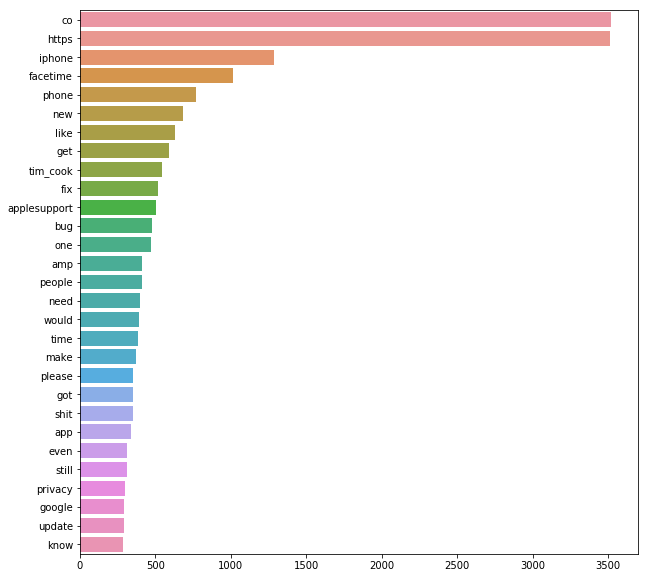

In [65]:
# Ignoring top word (which is "apple" in this case)
top_words = words_freq[1:30]

word = []
count = []

for i, j in top_words: 
    word.append(i)
    count.append(j)

# Asjusting figure size
plt.figure(figsize = (10,10))

# Plotting a barplot of most frequent words using Seaborn
sns.barplot(x = count, y = word)

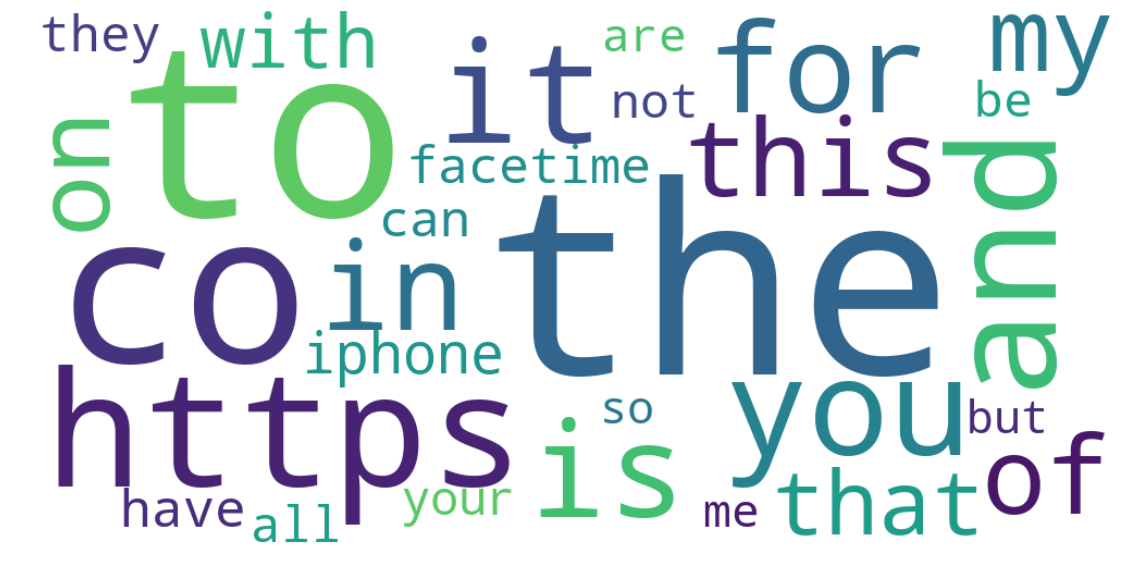

In [55]:
# Another way to plot most frequent words is through use of Wordclouds
words_dict = {}
for k,v in top_words:
    words_dict[k] = int(v)

# Using the WordCloud library
wordcloud = WordCloud(width=1000, height=500, background_color="white").generate_from_frequencies(words_dict)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [70]:
# It's clear that some terms like 'https' and 'co' refer to URLS and are not very useful to us. We can go about 
# removing them as so:
# top_words.remove(('https', 3510))
top_words.remove(('co', 3521))

In [71]:
top_words

[('iphone', 1284),
 ('facetime', 1014),
 ('phone', 766),
 ('new', 684),
 ('like', 629),
 ('get', 592),
 ('tim_cook', 546),
 ('fix', 518),
 ('applesupport', 507),
 ('bug', 478),
 ('one', 469),
 ('amp', 414),
 ('people', 408),
 ('need', 399),
 ('would', 393),
 ('time', 384),
 ('make', 369),
 ('please', 352),
 ('got', 350),
 ('shit', 349),
 ('app', 338),
 ('even', 314),
 ('still', 311),
 ('privacy', 299),
 ('google', 295),
 ('update', 291),
 ('know', 287)]

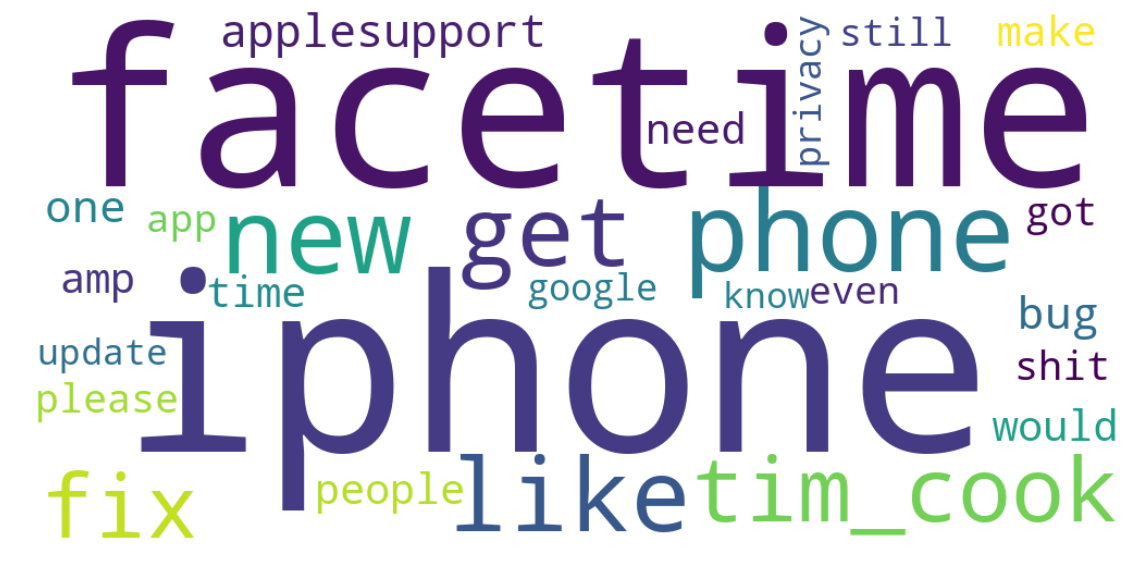

In [72]:
# Let's try again!
words_dict = {}
for k,v in top_words:
    words_dict[k] = int(v)

wordcloud = WordCloud(width=1000, height=500, background_color="white").generate_from_frequencies(words_dict)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### Model and Understand – Sentiment analysis

Now that we visualised most frequent words, we can delve into more interesting aspects, like sentiment. 


To do this, we'll be using a library called **Textblob**. The package assigns a _sentiment polarity score_ from -1 to 1 to each of our words. It then calculates the sum total sentiment polarity for each tweet by averaging the scores for the terms in the tweet in question. 

Textblob assigns sentiment scores based on pre-populated lexicon, or dictionary of words that have been previously assigned scores by humans -- no magic here! For more information on how the scoring is calculated read more [here](https://planspace.org/20150607-textblob_sentiment/). 

In [27]:
# We create a list of sentiment scores on each of our tweets using Textblob
sentiments = []

for tweet in tweets:
    analysis = TextBlob(tweet)
    sentiments.append(analysis.sentiment.polarity)

# We add that list to a new dataframe of our tweets
tweets_df = pd.DataFrame(tweets)

tweets_df['sentiments'] = sentiments

tweets_df

,text,sentiments
0,It’s true that @Apple likely overpriced the la...,0.158333
1,@AaronSuplizio @Apple Yes it is.,0.000000
2,"@mvigod @Apple As I have said many times here,...",0.000000
3,I’m not saying that @Apple doesn’t have proble...,0.000000
4,@DaveLeeBBC @Apple @NYGovCuomo Nor I; saw it g...,-0.155556
5,So: @Apple has now disabled Group #Facetime ht...,0.046212
6,I wish @tim_cook &amp; @apple tweeted the stat...,0.000000
7,"Any word on a time to fix, @tim_cook &amp; @ap...",0.000000
8,@DaveLeeBBC @Apple @NYGovCuomo I used to be on...,0.000000
9,3/ @Apple is biggest welfare taker of all time...,0.000000


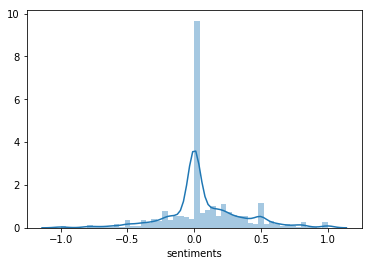

In [28]:
ax = sns.distplot(tweets_df['sentiments'])

In [36]:
# Create a new column that categorises sentiment -- 'Negative' if <0, 'Positive' if >0 and 'Neutral' if equal to 0.
categories = []

for sentiment in tweets_df['sentiments']: 
    if sentiment > 0:
        categories.append('Positive')
    elif sentiment < 0: 
        categories.append('Negative')
    else:
        categories.append('Neutral')
        

tweets_df['sentiment_category'] = categories

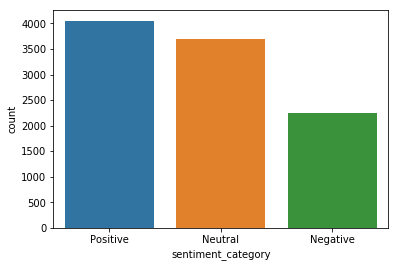

In [37]:

ax = sns.countplot(x = 'sentiment_category', data=tweets_df)

### Predict Sentiment – Text Classification

Now that we've explored our data (although not exhaustively) let's see if we can build a machine learning model that is able to predict the sentiment of a tweet!

In [28]:
tweets_df

,text,sentiments,sentiment_category
0,’ true apple likely overpriced latest iphones ...,0.190000,Positive
1,aaronsuplizio apple yes .,0.000000,Neutral
2,"mvigod apple said many times , regard multiple...",0.000000,Neutral
3,’ saying apple ’ problems challenges . . ’ say...,0.000000,Neutral
4,daveleebbc apple nygovcuomo ; saw go tracked c...,0.000000,Neutral
5,: apple disabled group facetime https : //t.co...,-0.018615,Negative
6,wish tim_cook & amp ; apple tweeted statement ...,0.000000,Neutral
7,"word time fix , tim_cook & amp ; apple https :...",0.000000,Neutral
8,"daveleebbc apple nygovcuomo used , back wanted...",0.000000,Neutral
9,3/ apple biggest welfare taker time $ 120 bill...,0.000000,Neutral


In [29]:
# We first drop the 'sentiments' column as it's redundant to use it to predict the 'sentiment_category'!
tweets_df.drop('sentiments', axis=1, inplace=  True)

tweets_df

,text,sentiment_category
0,’ true apple likely overpriced latest iphones ...,Positive
1,aaronsuplizio apple yes .,Neutral
2,"mvigod apple said many times , regard multiple...",Neutral
3,’ saying apple ’ problems challenges . . ’ say...,Neutral
4,daveleebbc apple nygovcuomo ; saw go tracked c...,Neutral
5,: apple disabled group facetime https : //t.co...,Negative
6,wish tim_cook & amp ; apple tweeted statement ...,Neutral
7,"word time fix , tim_cook & amp ; apple https :...",Neutral
8,"daveleebbc apple nygovcuomo used , back wanted...",Neutral
9,3/ apple biggest welfare taker time $ 120 bill...,Neutral


In [30]:
# Back to our bag-of-words model!
vector = CountVectorizer(max_features= 10000 , min_df=0.01, ngram_range= (1,1))

We split into a training and a testing set as before -- specifying: 
 - test_size = 0.3 -- i.e. we train on 70% of our dataset and test on 30%
 - a random_state = 123 -- for our results to be reproducible

In [31]:
# Using the train_test_split function
x_train, x_test, y_train, y_test = train_test_split(tweets_df['text'], tweets_df['sentiment_category'],  
                                                   test_size = 0.3, random_state = 123)

In [32]:
# Let's see what our x_train looks like! I.e. our text data in our training set 
x_train

7548    samsungmobile samsungmobilein redmiindia lavam...
1725    love apple picture actually funny related face...
6726         apple fucking sucks ever change android hell
2319    ’ going let ftc v qualcomm courtroom couple mi...
5208            apple ’ shit back , get new emojis tho 🤔😂
2984                                oh yea ’ acting apple
6219                thank apple https : //t.co/efxjtljdhv
8822    shotoniphone shotoniphonex apple pictures shot...
6126                      issa evil world live apple wild
1595    apple catch go apple tomorrow upgrade . ’ expe...
1618    thoughts apple 's rumored subscription gaming ...
2771    apple airpods shower big question yanis debbou...
4284    've dealt countless technical support biggest ...
5560    guys lie , brother tried , hear , ’ even answe...
608     apple apple facetimegate bring back green ligh...
9530                                      apple beautiful
1103    true . oems apple need soc ( apu+modem ) , int...
3158    see , 

In [33]:
# Just to check, we can print the shape of each of our quadrants -- x_train, and x_test
print(x_train.shape,  x_test.shape)

# y_train and y_test
print(y_train.shape, y_test.shape)

(6993,) (2998,)
(6993,) (2998,)


We now apply our bag of words model to our entire text using the _fit_ function

In [34]:
# Fit bag of words model (Countvectorizer) to full text first
vector.fit(tweets_df['text'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=10000, min_df=0.01,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [35]:
# Now we apply same feature transformation to both x_train, and x_test
x_train_bow = vector.transform(x_train)

x_test_bow = vector.transform(x_test)

In [36]:
print(x_train_bow)

  (0, 11)	1
  (0, 12)	1
  (0, 24)	1
  (0, 57)	1
  (0, 93)	1
  (1, 11)	2
  (1, 24)	1
  (1, 37)	1
  (1, 57)	1
  (1, 71)	1
  (2, 7)	1
  (2, 11)	1
  (2, 23)	1
  (2, 34)	1
  (3, 6)	1
  (3, 11)	1
  (3, 42)	1
  (3, 43)	1
  (3, 47)	1
  (3, 65)	1
  (3, 76)	1
  (3, 90)	1
  (3, 103)	1
  (3, 123)	1
  (4, 11)	1
  :	:
  (6987, 11)	3
  (6987, 65)	1
  (6988, 11)	1
  (6988, 55)	1
  (6988, 82)	1
  (6989, 11)	1
  (6989, 58)	1
  (6989, 86)	1
  (6990, 7)	1
  (6990, 11)	2
  (6990, 46)	1
  (6990, 75)	1
  (6991, 11)	1
  (6991, 18)	1
  (6991, 24)	1
  (6991, 57)	1
  (6992, 11)	1
  (6992, 12)	1
  (6992, 23)	1
  (6992, 67)	1
  (6992, 75)	1
  (6992, 99)	2
  (6992, 108)	2
  (6992, 131)	1
  (6992, 138)	1


In [37]:
# Notice the same number of features 
print(x_train_bow.shape, x_test_bow.shape)

(6993, 148) (2998, 148)


In [38]:
vector.get_feature_names()

['100',
 '2019',
 'airpods',
 'already',
 'also',
 'always',
 'amp',
 'android',
 'another',
 'answer',
 'app',
 'apple',
 'applesupport',
 'back',
 'battery',
 'best',
 'better',
 'big',
 'bug',
 'buy',
 'ca',
 'call',
 'camera',
 'change',
 'co',
 'come',
 'company',
 'could',
 'data',
 'day',
 'days',
 'devices',
 'done',
 'even',
 'ever',
 'every',
 'facebook',
 'facetime',
 'feature',
 'first',
 'fix',
 'fuck',
 'get',
 'getting',
 'give',
 'glitch',
 'go',
 'going',
 'good',
 'google',
 'got',
 'great',
 'group',
 'guys',
 'hear',
 'help',
 'hey',
 'https',
 'ios',
 'ipad',
 'iphone',
 'iphones',
 'issue',
 'know',
 'last',
 'let',
 'life',
 'like',
 'listen',
 'lol',
 'look',
 'love',
 'mac',
 'macbook',
 'made',
 'make',
 'many',
 'microsoft',
 'money',
 'much',
 'music',
 'na',
 'need',
 'needs',
 'never',
 'new',
 'next',
 'old',
 'one',
 'pay',
 'people',
 'phone',
 'phones',
 'please',
 'price',
 'privacy',
 'pro',
 'product',
 'products',
 'really',
 'right',
 'said',
 'sa

Now we can call on sklearn's machine learning algorithms!

One basic model that is typically used for text modelling is _Naive Bayes_.

In [39]:
# Using the MultinomialNB() function from sklearn
nb = MultinomialNB()
nb

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [40]:
# As with any machine learning model, we first fit/train it on the x_train_bow as our input and y_train on our output.
nb.fit(x_train_bow, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [41]:
# Make predictions based on new input, x_test_bow
predictions = nb.predict(x_test_bow)

predictions

array(['Negative', 'Neutral', 'Neutral', ..., 'Negative', 'Positive',
       'Neutral'], dtype='<U8')

In [42]:
# Print the accuracy score
accuracy_score(y_test, predictions)

0.6067378252168112

In [43]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

    Negative       0.56      0.26      0.36       681
     Neutral       0.56      0.82      0.67      1139
    Positive       0.69      0.60      0.64      1178

   micro avg       0.61      0.61      0.61      2998
   macro avg       0.61      0.56      0.56      2998
weighted avg       0.61      0.61      0.59      2998



Maybe try other machine learning algorithms?

In [44]:
# Trying the decision tree
tree = DecisionTreeClassifier()

# Fitting our tree
tree.fit(x_train_bow, y_train)

# Making predictions
predictions_tree = tree.predict(x_test_bow)

In [45]:
accuracy_score(y_test, predictions_tree)

0.5800533689126084

In [46]:
print(classification_report(y_test, predictions_tree))

              precision    recall  f1-score   support

    Negative       0.42      0.36      0.39       681
     Neutral       0.58      0.73      0.64      1139
    Positive       0.68      0.57      0.62      1178

   micro avg       0.58      0.58      0.58      2998
   macro avg       0.56      0.55      0.55      2998
weighted avg       0.58      0.58      0.57      2998



### Evaluate & Communicate

We've now built two separate predictive models, but that's just one possibility. There are many more ways we can explore this further. To name a few directions: 

 - We can improve the accuracy of our current models
 - We can try other machine learning models
 - We can try different pre-processing techniques
 - There are other modelling techniques besides the bag of words model -- maybe try TFIDF or Word2Vec? Lots you can explore here!

One of the most important parts of any data science project is communicating your findings. Think about what you've discovered, what you've learnt from it, and how you could use your new skills/knowledge within your organisation.